<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#6.1-매개변수-갱신" data-toc-modified-id="6.1-매개변수-갱신-1">6.1 매개변수 갱신</a></span><ul class="toc-item"><li><span><a href="#6.1.1-모험가-이야기" data-toc-modified-id="6.1.1-모험가-이야기-1.1">6.1.1 모험가 이야기</a></span></li><li><span><a href="#6.1.2-확률적-경사-하강법(SGD)" data-toc-modified-id="6.1.2-확률적-경사-하강법(SGD)-1.2">6.1.2 확률적 경사 하강법(SGD)</a></span></li><li><span><a href="#6.1.3-SGD의-단점" data-toc-modified-id="6.1.3-SGD의-단점-1.3">6.1.3 SGD의 단점</a></span></li><li><span><a href="#6.1.4-모멘텀" data-toc-modified-id="6.1.4-모멘텀-1.4">6.1.4 모멘텀</a></span></li><li><span><a href="#6.1.5-AdaGrad" data-toc-modified-id="6.1.5-AdaGrad-1.5">6.1.5 AdaGrad</a></span></li><li><span><a href="#6.1.6-Adam" data-toc-modified-id="6.1.6-Adam-1.6">6.1.6 Adam</a></span></li><li><span><a href="#6.1.7-어느-갱신-방법을-이용할-것인가?" data-toc-modified-id="6.1.7-어느-갱신-방법을-이용할-것인가?-1.7">6.1.7 어느 갱신 방법을 이용할 것인가?</a></span></li><li><span><a href="#6.1.8-MNIST-데이터셋으로-본-갱신-방법-비교" data-toc-modified-id="6.1.8-MNIST-데이터셋으로-본-갱신-방법-비교-1.8">6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교</a></span></li></ul></li><li><span><a href="#6.2-가중치의-초깃값" data-toc-modified-id="6.2-가중치의-초깃값-2">6.2 가중치의 초깃값</a></span><ul class="toc-item"><li><span><a href="#6.2.1-초깃값을-0으로-하면?" data-toc-modified-id="6.2.1-초깃값을-0으로-하면?-2.1">6.2.1 초깃값을 0으로 하면?</a></span></li><li><span><a href="#6.2.2-은닉층의-활성화값-분포" data-toc-modified-id="6.2.2-은닉층의-활성화값-분포-2.2">6.2.2 은닉층의 활성화값 분포</a></span></li><li><span><a href="#6.2.3-ReLU를-사용할-때의-가중치-초깃값" data-toc-modified-id="6.2.3-ReLU를-사용할-때의-가중치-초깃값-2.3">6.2.3 ReLU를 사용할 때의 가중치 초깃값</a></span></li><li><span><a href="#6.2.4-MNIST-데이터셋으로-본-가중치-초깃값-비교" data-toc-modified-id="6.2.4-MNIST-데이터셋으로-본-가중치-초깃값-비교-2.4">6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교</a></span></li></ul></li><li><span><a href="#6.3-배치-정규화" data-toc-modified-id="6.3-배치-정규화-3">6.3 배치 정규화</a></span><ul class="toc-item"><li><span><a href="#6.3.1-배치-정규화-알고리즘" data-toc-modified-id="6.3.1-배치-정규화-알고리즘-3.1">6.3.1 배치 정규화 알고리즘</a></span></li><li><span><a href="#6.3.2-배치-정규화의-효과" data-toc-modified-id="6.3.2-배치-정규화의-효과-3.2">6.3.2 배치 정규화의 효과</a></span></li></ul></li><li><span><a href="#6.4-바른-학습을-위해" data-toc-modified-id="6.4-바른-학습을-위해-4">6.4 바른 학습을 위해</a></span><ul class="toc-item"><li><span><a href="#6.4.1-오버피팅" data-toc-modified-id="6.4.1-오버피팅-4.1">6.4.1 오버피팅</a></span></li><li><span><a href="#6.4.2-가중치-감소" data-toc-modified-id="6.4.2-가중치-감소-4.2">6.4.2 가중치 감소</a></span></li><li><span><a href="#6.4.3-드롭아웃" data-toc-modified-id="6.4.3-드롭아웃-4.3">6.4.3 드롭아웃</a></span></li></ul></li><li><span><a href="#6.5-적절한-하이퍼파라미터-값-찾기" data-toc-modified-id="6.5-적절한-하이퍼파라미터-값-찾기-5">6.5 적절한 하이퍼파라미터 값 찾기</a></span><ul class="toc-item"><li><span><a href="#6.5.1-검증-데이터" data-toc-modified-id="6.5.1-검증-데이터-5.1">6.5.1 검증 데이터</a></span></li><li><span><a href="#6.5.2-하이퍼파라미터-최적화" data-toc-modified-id="6.5.2-하이퍼파라미터-최적화-5.2">6.5.2 하이퍼파라미터 최적화</a></span></li><li><span><a href="#6.5.3-하이퍼파라미터-최적화-구현하기" data-toc-modified-id="6.5.3-하이퍼파라미터-최적화-구현하기-5.3">6.5.3 하이퍼파라미터 최적화 구현하기</a></span></li></ul></li><li><span><a href="#6.6-정리" data-toc-modified-id="6.6-정리-6">6.6 정리</a></span></li></ul></div>

이번 장에서는 신경망 학습의 핵심 개념들을 만난다. 이번 장에서 다룰 주제는 가중치 매개변수의 최적값을 탐색하는 최적화 방법, 가중치 매개변수 초깃값, 하이퍼파라미터 설정 방법 등 모두가 신경망 학습에서 중요한 주제이다. 오버피팅의 대응책인 가중치 감소와 드롭아웃 등의 정규화 방법도 간략히 설명하고 구현해본다. 

# 6.1 매개변수 갱신
신경망 학습의 목적은 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것이다. 이는 곧 매개변수의 최적값을 찾는 문제이며, 이러한 문제를 푸는 것을 **최적화(Optimization)**라 한다. <br><br>
우리는 지금까지 최적의 매개변수 값을 찾는 단서로 매개변수의 기울기(미분)를 이용했다. 매개변수의 기울기를 구해, 기울어진 방향으로 매개변수 값을 갱신하는 일을 몇 번이고 반복해서 점점 최적의 값에 다가갔다. 이것이 **확률적 경사 하강법(SGD)**이란 단순한 방법인데, 매개변수 공간을 무작정 찾는 것보다 '똑똑한' 방법이다. 지금부터 SGD의 단점을 알아본 후 SGD와는 다른 최적화 기법을 소개한다.

## 6.1.1 모험가 이야기
모험가는 주위 경치는 볼 수 없지만 서있는 땅의 기울기는 알 수 있다. 지금 서 있는 장소에서 가장 크게 기울어진 방향으로 가자는 것이 SGD의 전략이다.

## 6.1.2 확률적 경사 하강법(SGD)
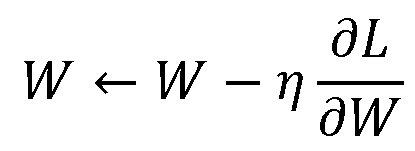

In [1]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]  # 각각 가중치 매개변수와 기울기를 저장

## 6.1.3 SGD의 단점
SGD는 단순하고 구현도 쉽지만, 문제에 따라서는 비효율적일 때가 있다. SGD의 단점을 알아보고자 다음 함수의 최솟값을 구하는 문제를 생각해본다.<br><br>
$$ f(x,y) = \frac{1}{20}x^2 + y^2 $$  


탐색을 시작하는 장소(초깃값)는 (x, y) = (-7.0, 2.0)으로 하여 SGD를 적용해본다. 결과는 다음과 같다.<br><br>
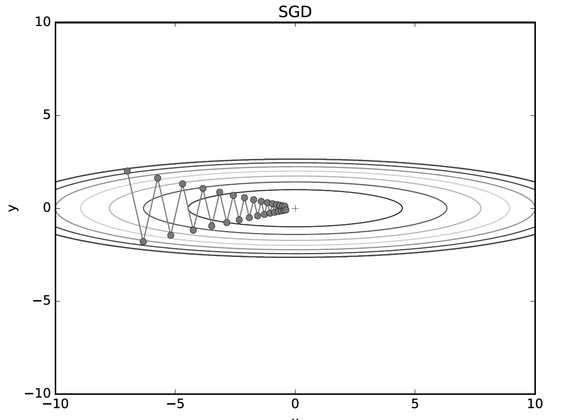

SGD는 위의 그림과 같이 심하게 굽이진 움직임을 보여준다. 상당히 비효율적인 움직임이다. 즉, SGD의 단점은 **비등방성 함수**(방향에 따라 성질, 즉 여기에서는 기울기가 달라지는 함수)에서는 탐색 경로가 비효율적이라는 것이다. 또한, SGD가 지그재그로 탐색하는 근본 원인은 기울어진 방향이 본래의 최솟값과 다른 방향을 가리켜서라는 점도 생각해볼 필요가 있다.  
이제부터 SGD의 이러한 단점을 개선해주는 **모멘텀, AdaGrad, Adam**이라는 세 방법을 소개할 것이다.

## 6.1.4 모멘텀
**모멘틈 (Momentum)**은 '운동량'을 뜻하는 단어로, 물리와 관계가 있다. 모멘텀 기법은 수식으로는 다음과 같이 쓸 수 있다.<br><br>
$$ v = \alpha v - \eta \frac{\alpha L}{\alpha W} $$<br><br>
$$ W = W + v $$<br>

위 식은 SGD처럼 W는 갱신할 가중치 매개변수, $ \frac{\alpha L}{\alpha W} $은 $W$에 대한 손실 함수의 기울기, $\eta$는 학습률이다.  
$v$라는 변수가 새로 나오는데, 이는 물리에서 말하는 속도에 해당한다. 식은 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타낸다.  
모멘텀은 그림과 같이 공이 그릇의 바닥을 구르는 듯한 움직임을 보여준다.

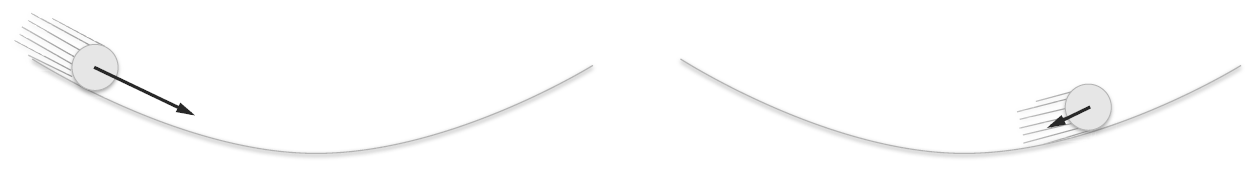

또, 식의 $\alpha v$항은 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할을 한다. ($\alpha$는 0.9등의 값으로 설정한다).  
물리에서의 지면 마찰이나 공기 저항에 해당한다. 다음은 모멘텀의 구현이다.

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

인스턴수 변수 v가 물체의 속도이다. v는 초기화 때는 아무 값도 담지 않고, 대신 update()가 처음 호출될 때 매개변수와 같은 구조의 데이터를 딕셔너리 변수로 저장한다.

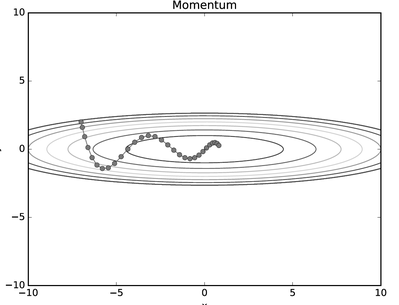<br>
그림에서 보듯 모멘텀의 갱신 경로는 공이 그릇 바닥을 구르듯 움직인다. SGD와 비교하면 '지그재그 정도'가 덜한 것을 알 수 있다. 이는 x축의 힘은 아주 작지만 방향은 변하지 않아서 한 방향으로 일정하게 가속하기 때문이다.<br><br>
거꾸로 y축의 힘은 크지만 위아래로 번갈아 받아서 상승하여 y축 방향의 속도는 안정적이지 않다.<br><br>
**전체적으로는 SGD보다 x축 방향으로 빠르게 다가가 지그재그 움직임이 줄어든다.**

## 6.1.5 AdaGrad
신경망 학습에서는 학습률($\eta$)값이 중요하다. 이 값이 너무 작으면 학습 시간이 너무 길어지고, 반대로 너무 크면 발산하여 학습이 제대로 이뤄지지 않는다.<br><br>
이 학습률을 정하는 효과적 기술로 **학습률 감소(learning rate decay)** 가 있다. 이는 학습을 진행하면서 학습을 점차 줄여가는 방법이다. 처음에는 크게 학습하다가 조금씩 작게 학습한다는 얘기로, 실제 신경망 학습에 자주 쓰인다.<br><br>
학습률을 서서히 낮추는 가장 간단한 방법은 매개변수 '전체'의 학습률 값을 일괄적으로 낮추는 것이다. 이를 더욱 발전시킨 것이 **AdaGrad**이다. AdaGrad는 '각각의' 매개변수에 '맞춤형' 값을 만들어 준다.

AdaGrad는 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행한다.<br><br>
AdaGrad의 갱신 방법은 수식으로는 다음과 같다.<br><br>
$$ h = h + \frac{\alpha L}{\alpha W} * \frac{\alpha L}{\alpha W} $$<br><br>
$$ W = W - \eta \frac{1}{\sqrt h}\frac{\alpha L}{\alpha W} $$

마찬가지로 W는 갱신할 가중치 매개변수, $\frac{\alpha L}{\alpha W}$은 $W$에 대한 손실 함수의 기울기, $\eta$는 학습률을 뜻한다.  
여기에서는 새로 $h$라는 변수가 등장한다. $h$는 위의 식에서 보듯 기존 기울기 값을 제곱하여 계속 더해준다. 그리고 매개변수를 갱신할 때 $\frac{1}{\sqrt h}$을 곱해 학습률을 조정한다.<br><br> 
매개변수의 원소 중에서 많이 움직인 원소는 학습률이 낮아진다는 뜻인데, 다시 말해 학습률 감소가 매개변수의 원소마다 다르게 적용됨을 뜻한다.

In [3]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))

여기에서 주의할 것은 마지막 줄에서 $1e-7$이라는 작은 값을 더하는 부분이다. 이 작은 값은 self.h[key]에 0이 담겨 있다 해도 0으로 나누는 사태를 막아준다. 대부분의 딥러닝 프레임워크에서는 이 값도 인수로 설정할 수 있다.

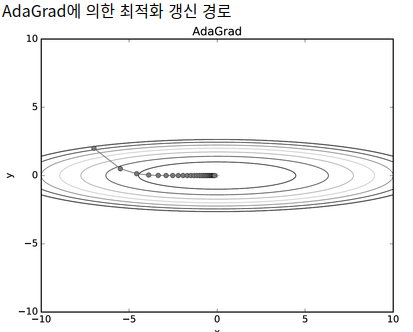

그림을 보면 최솟값을 향해 효율적으로 움직이는 것을 알 수 있다. y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정된다. 그래서 y축 방향으로 갱신 강도가 빠르게 약해지고, 지그재그 움직임이 줄어든다.

## 6.1.6 Adam
모멘텀은 공이 그릇 바닥을 구르는 듯한 움직임을 보였다. AdaGrad는 매개변수의 원소마다 적응적으로 갱신 정도를 조정하였다. 그럼 이 두 기법을 융합하여 출발한 기법이 바로 **Adam** 이다.<br><br>
**Adam** 은 직관적으로는 모멘텀과 AdaGrad를 융합한 듯한 방법으로, 하이퍼파라미터의 '편향 보정'이 진행된다는 특징이 있다.

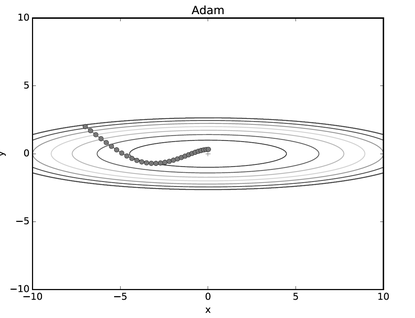

그림과 같이 Adam 갱신 과정도 그릇 바닥을 구르듯 움직인다. 모멘텀과 비슷한 패턴인데, 모멘텀 때보다 공의 좌우 흔들림이 적다. 이는 학습의 갱신 강도를 적응적으로 조정해서 얻는 혜택이다.

## 6.1.7 어느 갱신 방법을 이용할 것인가?
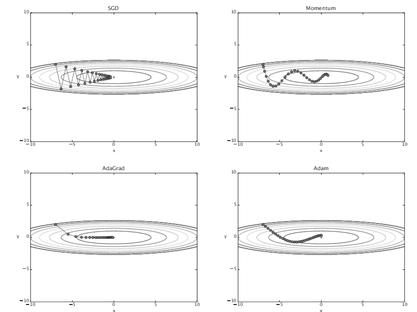<br><br>
SGD, 모멘텀, AdaGrad, Adam의 네 후보 중 유감스럽게도 모든 문제에서 항상 뛰어난 기법이라는 것은 (아직까진) 없다. 각자의 장단이 있어 잘 푸는 문제와 서툰 문제가 있다.<br><br>
지금도 많은 연구에서 SGD를 사용하고 있으며, 요즘에는 많은 사람들이 Adam에 만족해하며 쓰고 있다.

## 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교
손글씨 숫자 인식을 대상으로 지금까지 설명한 네 기법을 비교해본다.
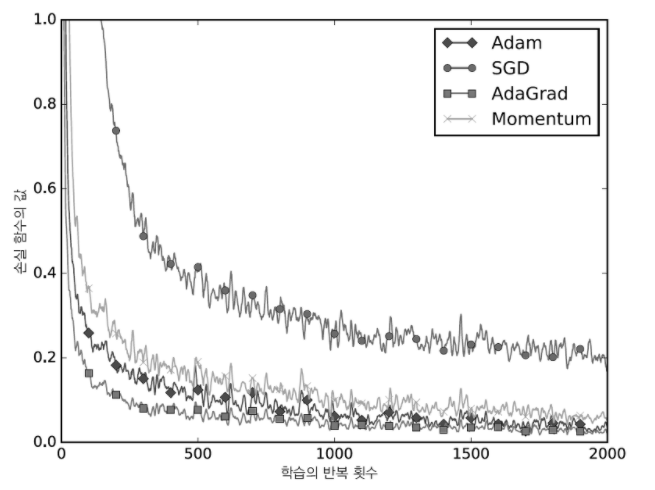<br><br>
결과를 보면 SGD의 학습 진도가 가장 느리다. 나머지 세 기법의 진도는 비슷한데, 잘 보면 AdaGrad가 조금 더 빠르다. 이 실험에서 주의할 점은 하이퍼파라미터인 학습률과 신경망의 구조에 따라 결과가 달라진다는 것이다.<br><br>
다만 일반적으로 SGD보다 다른 세 기법이 빠르게 학습하고, 때로는 최종 정확도도 높게 나타난다.

# 6.2 가중치의 초깃값
신경망 학습에서 특히 중요한 것이 가중치의 초깃값이다. 가중치의 초깃값을 무엇으로 설정하느냐가 신경망 학습의 성패가 가르는 일이 자주 있다. 

## 6.2.1 초깃값을 0으로 하면?
이제 오버피팅을 억제해 범용 성능을 높이는 테크닉인 **가중치 감소** 기법을 소개한다. 가중치 감소는 간단히 말하자면 가중치 매개변수의 값이 작아지도록 학습하는 방법이다. 가중치 값을 작게 하여 오버피팅이 일어나지 않게 하는 것이다.<br><br>

가중치를 작게 만들고 싶으면 초깃값도 최대한 작은 값에서 시작하는 것이 정공법이다. 그렇다면 가중치의 초깃값을 모두 0으로 설정하면 어떨까? 답부터 얘기하면, 이는 나쁜 아이디어이다. 실제로 가중치 초깃값을 0으로 하면 학습이 올바로 이뤄지지 않는다.<br><br>

초깃값을 0으로 하면 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문이다. 그래서 가중치가 고르게 되어버리는 상황을 막으려면 초깃값을 무작위로 설정해야 한다.

## 6.2.2 은닉층의 활성화값 분포
은닉층의 활성화값(활성화 함수의 출력 데이터)의 분포를 관찰하면 중요한 정보를 얻을 수 있다. 이번 절에서는 가중치의 초깃값에 따라 은닉층 활성화값들이 어떻게 변화하는지 간단한 실험을 해본다.<br><br>
구체적으로는 활성화 함수로 시그모이드 함수를 사용하는 5층 신경망에 무작위로 생성한 입력 데이터를 흘리며 각 층의 활성화값 분포를 히스토그램으로 그려본다.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100                 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5          # 5개의 은닉층
activations = {}               # 이곳에 활성화 결과(활성화값)를 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

층이 5개가 있으며, 각 층의 뉴런은 100개씩이다. 입력 데이터로서 1,000개의 데이터를 정규분포로 무작위로 생성하여 이 5층 신경망에 흘린다. 활성화 함수로는 시그모이드 함수를 이용했고, 각 층의 활성화 결과를 activations 변수에 저장한다.<br><br>
이 코드에서는 가중치의 분포에 주의해야 한다. 이번에는 표준편차가 1인 정규분포를 이용했는데, 이 분포된 정도(표준편차)를 바꿔가며 활성화값들의 분포가 어떻게 변화하는지 관찰하는 것이 이 실험의 목적이다.

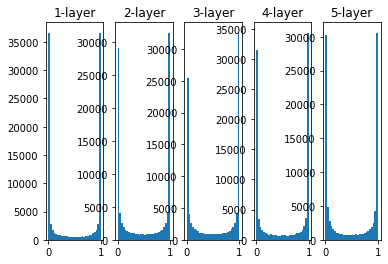

In [10]:
# 히스토그램 늘리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
    
plt.show()

각 층의 활성화값들이 0과 1에 치우쳐 분포되어 있다. 여기서 사용한 시그모이드 함수는 그 출력이 0에 가까워지자(또는 1에 가까워지자) 그 미분은 0에 다가간다. 그래서 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라진다. 이것이 **기울기 소실** 이다. 층을 깊게 하는 딥러닝에서는 기울기 소실은 더 심각한 문제가 될 수 있다.

이번에는 가중치의 표준 편차를 0.01로 바꿔 같은 실험을 반복한다.

In [11]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]
        
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

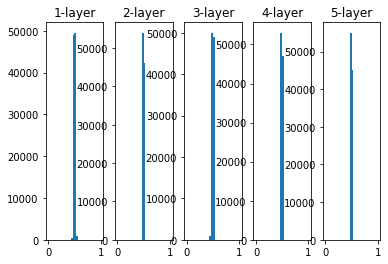

In [12]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
    
plt.show()

이번에는 0.5 부근에 집중되었다. 앞의 예처럼 0과 1로 치우치지 않아서 기울기 소실 문제는 일어나지 않으나, 활성화값들이 치우쳤다는 것은 표현력 관점에서는 큰 문제가 있는 것이다.<br><br>
이 상황에서는 다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어진다는 뜻이다. 그래서 활성화값들이 치우치면 **표현력을 제한**한다는 관점에서 문제가 된다.

**Xavier 초깃값**은 일반적인 딥러닝 프레임워크들이 표준적으로 이용하고 있다. 예를 들어 카페 프레임워크는 가중치 초깃값을 설정할 때 인수로 xavier를 지정할 수 있다.<br><br>
이 논문은 각 층의 활성화값들을 광법위하게 분포시킬 목적으로 가중치의 적절한 분포를 찾고자 하였다. 그리고 앞 계층의 노드가 $n$개라면 표준편차가 $\frac{1}{\sqrt n}$인 분포를 사용하면 된다는 결론을 이끌었다.
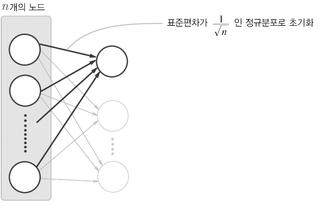<br><br>
Xabier 초깃값을 사용하면 앞 층에 노드가 많을수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 펴진다. 이제 Xavier 초깃값을 써서 실험해본다.

In [13]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

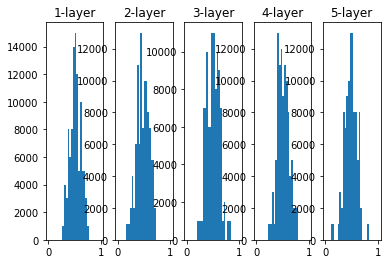

In [15]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i + 1)
    plt.title(str(i + 1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
    
plt.show()

Xavier 초깃값을 사용한 결과를 보면 층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다는 확실히 넓게 분포됨을 알 수 있다. 각 층에 흐르는 데이터는 적당히 퍼져 있으므로, 시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것으로 기대된다.

## 6.2.3 ReLU를 사용할 때의 가중치 초깃값
Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과이다. sigmoid 함수와 tanh 함수는 좌우 대칭이라 중앙 부근이 선형인 함수로 볼 수 있다. 그래서 Xavier 초깃값이 적당하다. 반면 ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용하라고 권장한다. 이 특화된 초깃값을 찾아낸 카이밍 히의 이름을 따 **He 초깃값** 이라고 한다. 다음은 활성화 함수로 ReLU를 이용한 경우의 활성화 값 분포이다.

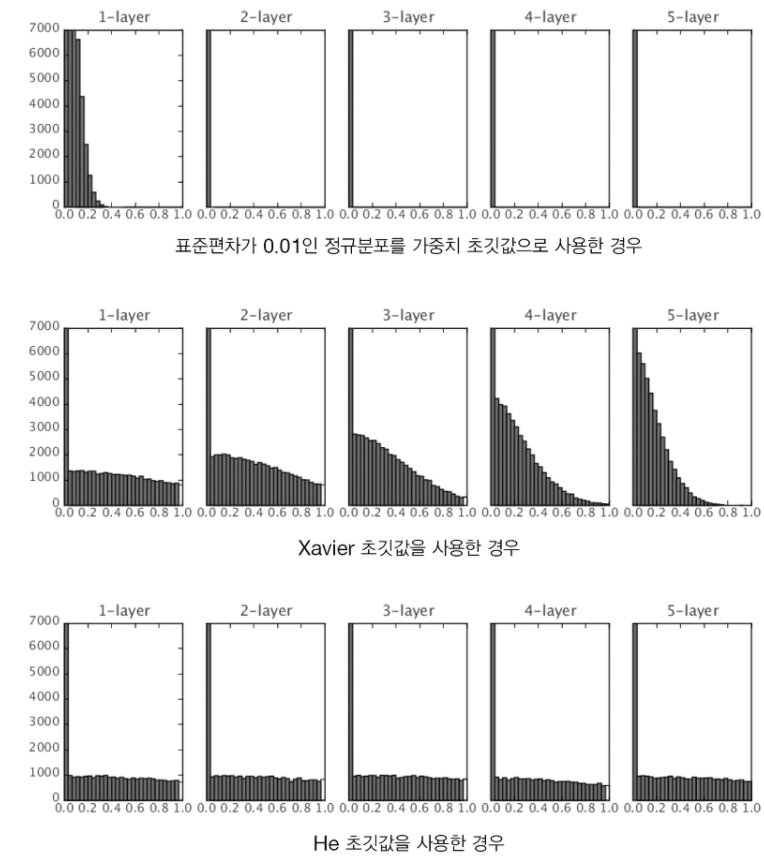

결과를 보면 std = 0.01일 때의 각 층의 활성화 값들은 아주 작은 값들이다. 신경망에 아주 작은 데이터가 흐른다는 것은 역전파 때 가중치의 기울기 역시 작아진다는 뜻이다. 실제로도 학습은 거의 이뤄지지 않는다.<br><br>
이어서 Xavier 초깃값 결과를 보면 층이 깊어지면서 치우침이 조금씩 커진다. 실제로 층이 깊어지면 활성화값들의 치우침도 커지고, 학습할 때 '기울기 소실'문제를 일으킨다.<br><br>
마지막으로 He 초깃값은 모든 층에서 균일하게 분포되었다. 층이 깊어져도 분포가 균일하게 유지되기에 역전파 때도 적절한 값이 나올 것으로 기대할 수 있다. <br><br>
이상의 실험 결과를 바탕으로, 활성화 함수로 ReLU를 사용할 때는 He 초깃값을, sigmoid나 tanh 등의 S자 모양 곡선일 때는 Xavier 초깃값을 사용한다.

## 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교
실제 데이터를 가지고 가중치의 초깃값을 주는 방법이 신경망 학습에 얼마나 영향을 주는지 알아본다. <br><br>
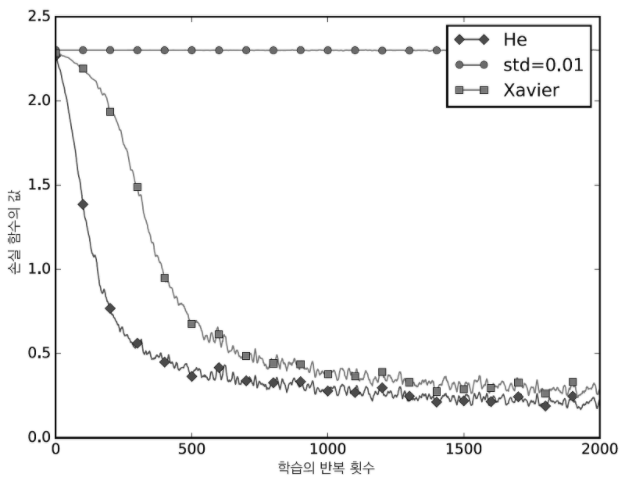<br><br>
이 실험은 층별 뉴런 수가 100개인 5층 신경망에서 활성화 함수로 ReLU를 사용하였다. std=0.01일 때는 학습이 전혀 이뤄지지 않는다. 반대로 Xavier와 He 초깃값의 경우는 학습이 순조롭게 이뤄지고 있다. 다만 학습 진도는 He 초깃값 쪽이 더 빠르다.<br><br>
**가중치의 초깃값은 신경망 학습에 아주 중요한 포인트이다.**

# 6.3 배치 정규화
각 층이 활성화를 적당히 퍼뜨리도록 '강제'하는 **배치 정규화**에 대해서 알아본다.

## 6.3.1 배치 정규화 알고리즘
- 학습을 빨리 진행할 수 있다 (학습 속도 개선)
- 초깃값에 크게 의존하지 않는다.
- 오버피팅을 억제한다. (드롭아웃 등의 필요성 감소)

배치 정규화의 기본 아이디어는 각 층에서의 활성화 값이 적당히 분포되도록 조정하는 것이다. <br><br>
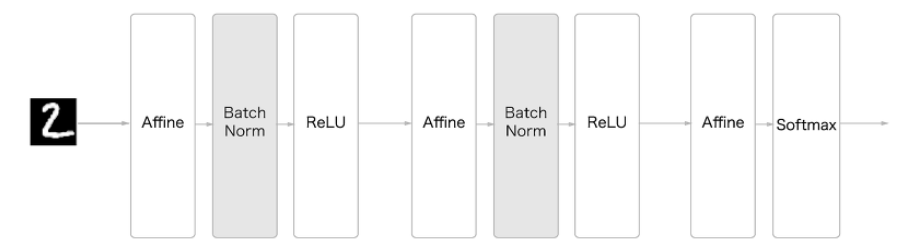<br><br>
따라서 그림과 같이 데이터 분포를 정규화하는 '배치 정규화 계층'을 신경망에 삽입한다.<br><br>
배치 정규화는 그 이름과 같이 학습 시 미니배치를 단위로 정규화한다. 구체적으로는 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화한다. 수식으로는 다음과 같다. <br><br>
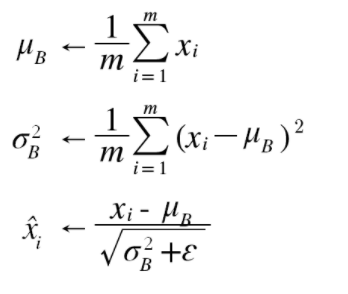

여기에는 미니배치 B라는 m개의 입력 데이터의 집합에 대해 평균과 분산을 구한다. 그리고 입력 데이터를 평균이 0, 분산이 1ㅣ이 되게 정규화한다. 또, 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대와 이동 변환을 수행한다.<br><br>
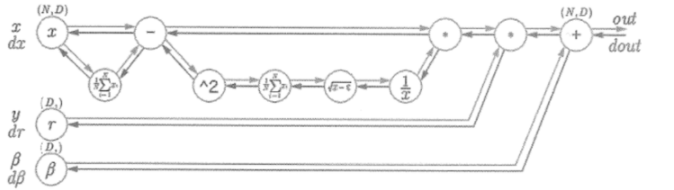<br><br>
이상이 배치 정규화의 알고리즘이다. 이 알고리즘이 신경망에서 순전파 때 적용된다.

## 6.3.2 배치 정규화의 효과
MNIST 데이터셋을 사용하여 배치 정규화 계층을 사용할 때와 사용하지 않을 때의 학습 진도가 어떻게 달라지는지를 살펴본다. <br><br>
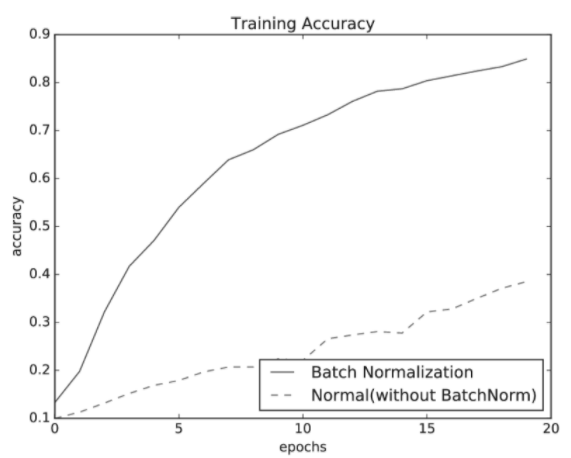<br><br>
그림과 같이 배치 정규화가 학습을 빨리 진전시키고 있다. 계속해서 초깃값 분포를 다양하게 줘가며 학습 진행이 어떻게 달라지는지 살펴본다. 다음은 가중치 초깃값의 표준편차를 다양하게 바꿔가며 학습 경과를 관찰한 그래프이다. 

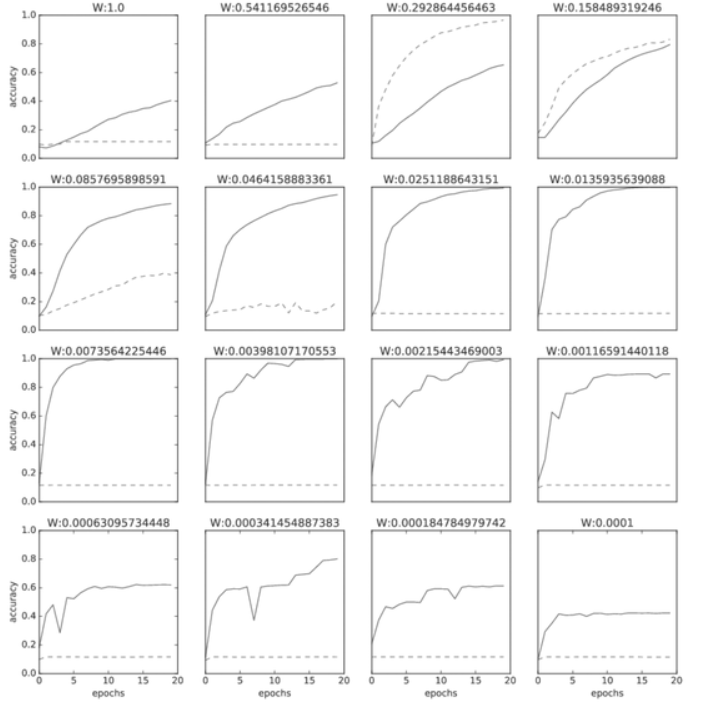<br><br>
거의 모든 경우에서 배치 정규화를 사용할 때의 학습 진도가 빠른 것으로 나타난다. 실제로 배치 정규화를 이용하지 않는 경우엔 초깃값이 잘 분포되어 있지 않으면 학습이 전혀 진행되지 않는 모습도 확인할 수 있다.<br><br>
**이처럼 배치 정규화를 사용하면 학습이 빨라지며, 가중치 초깃값에 크게 의존하지 않아도 된다.**

# 6.4 바른 학습을 위해
기계학습에서는 **오버피팅**이 문제가 되는 일이 많다. 오버피팅이란 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태를 말한다. 기계학습은 범용 성능을 지향한다. 훈련 데이터에는 포함되지 않는, 아직 보지 못한 데이터가 주어져도 바르게 식별해내는 모델이 바람직하다.

## 6.4.1 오버피팅
오버피팅은 주로 다음의 두 경우에 일어난다.
- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적음
이번 장에서는 이 두 요건을 일부러 충족하여 오버피팅을 일으켜본다. 그러기 위해 본래 60,000개인 MNIST 데이터셋의 훈련 데이터 중 300개만 사용하고, 7층 네트워크를 사용하여 네트워크의 복잡성을 높인다. 각 층의 뉴런은 100개, 활성화 함수는 ReLU를 사용한다.

In [16]:
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [21]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.09333333333333334, test acc:0.0983
epoch:1, train acc:0.1, test acc:0.1028
epoch:2, train acc:0.13, test acc:0.1123
epoch:3, train acc:0.13666666666666666, test acc:0.1185
epoch:4, train acc:0.16, test acc:0.1277
epoch:5, train acc:0.17666666666666667, test acc:0.1371
epoch:6, train acc:0.18333333333333332, test acc:0.1483
epoch:7, train acc:0.21333333333333335, test acc:0.1619
epoch:8, train acc:0.26, test acc:0.1881
epoch:9, train acc:0.3, test acc:0.2158
epoch:10, train acc:0.37333333333333335, test acc:0.2492
epoch:11, train acc:0.39, test acc:0.2809
epoch:12, train acc:0.4266666666666667, test acc:0.3062
epoch:13, train acc:0.4666666666666667, test acc:0.32
epoch:14, train acc:0.49333333333333335, test acc:0.342
epoch:15, train acc:0.53, test acc:0.3586
epoch:16, train acc:0.54, test acc:0.3792
epoch:17, train acc:0.5533333333333333, test acc:0.3953
epoch:18, train acc:0.5966666666666667, test acc:0.4078
epoch:19, train acc:0.6133333333333333, test acc:0.4233


epoch:166, train acc:1.0, test acc:0.7557
epoch:167, train acc:1.0, test acc:0.7577
epoch:168, train acc:1.0, test acc:0.7597
epoch:169, train acc:1.0, test acc:0.7597
epoch:170, train acc:1.0, test acc:0.7606
epoch:171, train acc:1.0, test acc:0.7602
epoch:172, train acc:1.0, test acc:0.759
epoch:173, train acc:1.0, test acc:0.7609
epoch:174, train acc:1.0, test acc:0.76
epoch:175, train acc:1.0, test acc:0.7617
epoch:176, train acc:1.0, test acc:0.76
epoch:177, train acc:1.0, test acc:0.7599
epoch:178, train acc:1.0, test acc:0.7599
epoch:179, train acc:1.0, test acc:0.7628
epoch:180, train acc:1.0, test acc:0.7624
epoch:181, train acc:1.0, test acc:0.761
epoch:182, train acc:1.0, test acc:0.7613
epoch:183, train acc:1.0, test acc:0.7621
epoch:184, train acc:1.0, test acc:0.7616
epoch:185, train acc:1.0, test acc:0.7622
epoch:186, train acc:1.0, test acc:0.7575
epoch:187, train acc:1.0, test acc:0.7591
epoch:188, train acc:1.0, test acc:0.7605
epoch:189, train acc:1.0, test acc:0.760

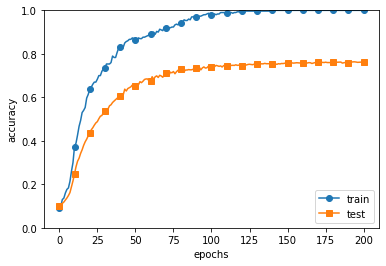

In [22]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

훈련 데이터를 사용하여 측정한 정확도는 100 에폭을 지나는 무렵부터는 거의 100% 이다. 그러나 시험 데이터에 대해서는 큰 차이를 나타낸다. 이처럼 정확도가 크게 벌어지는 것은 훈련 데이터에만 적응해버린 결과이다.

## 6.4.2 가중치 감소
오버피팅 억제용으로 예로부터 많이 이용해온 방법 중 **가중치 감소**가 있다. 이는 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법이다. 원래 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문이다.<br><br>
가중치 감소는 모든 가중치 각각의 손실 함수에 $\frac{1}{2}\lambda W^2$를 더한다. 따라서 가중치의 기울기를 구하는 계산에서는 그동안의 오차역전파법에 따른 결과에 정규화 항을 미분한 $\lambda W$를 더한다.

In [23]:
# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

In [25]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

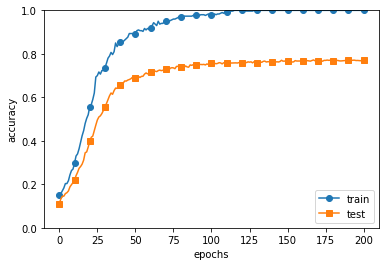

In [26]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

방금 수행한 실험에서 $\lambda$ = 0.1로 가중치 감소를 적용하였더니 훈련 데이터에 대한 정확도와 시험 데이터에 대한 정확도에는 여전히 차이가 있지만, 이전과 비교하면 그 차이가 줄었다. 다시말해 오버피팅이 억제됐다는 소리이다. 그리고 앞서와 달리 훈련 데이터에 대한 정확도가 100%에 도달하지 못한 점도 주목해야 한다.

## 6.4.3 드롭아웃
앞 절에서는 오버피팅을 억제하는 방식으로 손실 함수에 가중치의 L2 노름을 더한 가중치 감소 방법을 설명하였다. 가중치 감소는 간단하게 구현할 수 있고 어느 정도 지나친 학습을 억제할 수 있다. 그러나 신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려워진다. 이럴 때는 흔히 **드롭아웃**이라는 기법을 이용한다. <br><br>
드롭아웃은 뉴런을 임의로 삭제하면서 학습하는 방법이다. 훈련 때 은닉층의 뉴런을 무작위로 골라 삭제한다. 삭제된 뉴런은 그림과 같이 신호를 전달하지 않게 된다. 훈련 때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달한다. **단, 시험 때는 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 출력한다.**
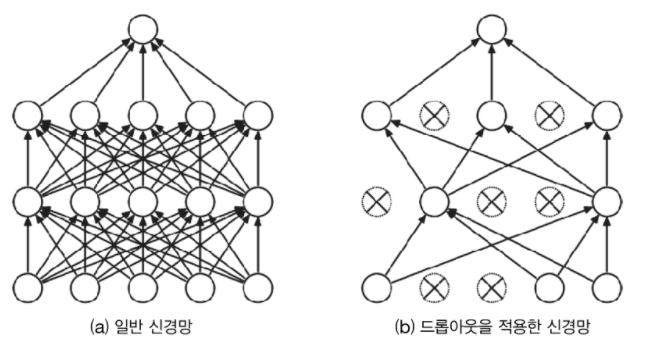

In [27]:
# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

train loss:2.2976929269856172
=== epoch:1, train acc:0.11333333333333333, test acc:0.1102 ===
train loss:2.295928276396669
train loss:2.287428935077328
train loss:2.2984996043980273
=== epoch:2, train acc:0.12, test acc:0.113 ===
train loss:2.290410678327797
train loss:2.2997411480227474
train loss:2.296206584793674
=== epoch:3, train acc:0.12333333333333334, test acc:0.1145 ===
train loss:2.298832133384264
train loss:2.295725696549028
train loss:2.3043978481057668
=== epoch:4, train acc:0.12333333333333334, test acc:0.1145 ===
train loss:2.290444190675729
train loss:2.2940131734956553
train loss:2.3034167378033783
=== epoch:5, train acc:0.12, test acc:0.1177 ===
train loss:2.2782349317835577
train loss:2.3023127606702234
train loss:2.2997929255202703
=== epoch:6, train acc:0.12666666666666668, test acc:0.1199 ===
train loss:2.288355333448796
train loss:2.297948851979386
train loss:2.3034565147404105
=== epoch:7, train acc:0.14333333333333334, test acc:0.1219 ===
train loss:2.290721051

=== epoch:56, train acc:0.3566666666666667, test acc:0.2723 ===
train loss:2.2499796638393095
train loss:2.236044615001491
train loss:2.2395543400821447
=== epoch:57, train acc:0.35333333333333333, test acc:0.2731 ===
train loss:2.238160544245723
train loss:2.2399779412454754
train loss:2.2377173324355413
=== epoch:58, train acc:0.3566666666666667, test acc:0.2736 ===
train loss:2.2412570535149667
train loss:2.217626080603894
train loss:2.248968160661947
=== epoch:59, train acc:0.36, test acc:0.2736 ===
train loss:2.248517158632019
train loss:2.2471793505900113
train loss:2.2420328215353873
=== epoch:60, train acc:0.36333333333333334, test acc:0.2761 ===
train loss:2.2462120323753547
train loss:2.240555739932707
train loss:2.233166362715207
=== epoch:61, train acc:0.3566666666666667, test acc:0.2774 ===
train loss:2.2337856430530194
train loss:2.23026800119495
train loss:2.2357425884697673
=== epoch:62, train acc:0.36333333333333334, test acc:0.2789 ===
train loss:2.2343513759099083
tr

=== epoch:112, train acc:0.34, test acc:0.2887 ===
train loss:2.1320330500668123
train loss:2.126700896404058
train loss:2.117859874727939
=== epoch:113, train acc:0.34, test acc:0.2897 ===
train loss:2.1091611641549592
train loss:2.135104377213836
train loss:2.092115242715636
=== epoch:114, train acc:0.34, test acc:0.2911 ===
train loss:2.127272116542693
train loss:2.1262050071454532
train loss:2.0878315415735123
=== epoch:115, train acc:0.3433333333333333, test acc:0.2933 ===
train loss:2.1563767704481682
train loss:2.113839666590971
train loss:2.0952346473064845
=== epoch:116, train acc:0.3466666666666667, test acc:0.294 ===
train loss:2.0907297469647768
train loss:2.105439076984459
train loss:2.1262658928241525
=== epoch:117, train acc:0.35, test acc:0.2941 ===
train loss:2.136454374098476
train loss:2.100205843132834
train loss:2.0713081020115327
=== epoch:118, train acc:0.3433333333333333, test acc:0.2936 ===
train loss:2.1467024012582256
train loss:2.1285199401229287
train loss:

=== epoch:167, train acc:0.3933333333333333, test acc:0.3094 ===
train loss:1.9176076587757092
train loss:1.9090461664224756
train loss:1.8535501959747342
=== epoch:168, train acc:0.4, test acc:0.3124 ===
train loss:1.862885740726547
train loss:1.8115401076806834
train loss:1.8429730953775836
=== epoch:169, train acc:0.4, test acc:0.3145 ===
train loss:1.8772107563744271
train loss:1.8287502020047384
train loss:1.8577064113586303
=== epoch:170, train acc:0.3933333333333333, test acc:0.316 ===
train loss:1.8304795310644237
train loss:1.9232168005616197
train loss:1.8612670605755517
=== epoch:171, train acc:0.39666666666666667, test acc:0.3177 ===
train loss:1.705775210665775
train loss:1.751770671279802
train loss:1.793702203839424
=== epoch:172, train acc:0.4033333333333333, test acc:0.3149 ===
train loss:1.742535466831338
train loss:1.7760945063863574
train loss:1.7932907185561084
=== epoch:173, train acc:0.4033333333333333, test acc:0.3138 ===
train loss:1.8019747957231724
train loss

=== epoch:222, train acc:0.5, test acc:0.3932 ===
train loss:1.4837216181431925
train loss:1.6316421611880247
train loss:1.5403134232821905
=== epoch:223, train acc:0.5, test acc:0.3919 ===
train loss:1.497309760573271
train loss:1.5521283811225706
train loss:1.4520603018376417
=== epoch:224, train acc:0.5033333333333333, test acc:0.3955 ===
train loss:1.456891133899782
train loss:1.5428188676370131
train loss:1.486084933527852
=== epoch:225, train acc:0.49666666666666665, test acc:0.3947 ===
train loss:1.56478958619489
train loss:1.5509090109462869
train loss:1.6024012662283618
=== epoch:226, train acc:0.5033333333333333, test acc:0.4003 ===
train loss:1.6717051761964337
train loss:1.5868273067969931
train loss:1.51498699382777
=== epoch:227, train acc:0.5033333333333333, test acc:0.4044 ===
train loss:1.4359922700804126
train loss:1.539587714479504
train loss:1.5535145465008176
=== epoch:228, train acc:0.5033333333333333, test acc:0.4011 ===
train loss:1.553905193816416
train loss:1.

=== epoch:277, train acc:0.6166666666666667, test acc:0.5105 ===
train loss:1.1777850053528298
train loss:1.2736175562376195
train loss:1.1637173293956733
=== epoch:278, train acc:0.6133333333333333, test acc:0.5064 ===
train loss:1.3481617905575398
train loss:1.2230412730542137
train loss:1.1318127783335936
=== epoch:279, train acc:0.6066666666666667, test acc:0.5045 ===
train loss:1.3683301024457832
train loss:1.2267549409072709
train loss:1.2829709801155509
=== epoch:280, train acc:0.61, test acc:0.5103 ===
train loss:1.1704605243724013
train loss:1.1813265582126702
train loss:1.0441919965372317
=== epoch:281, train acc:0.61, test acc:0.5056 ===
train loss:1.3798571079374764
train loss:1.0986821414420165
train loss:1.1638781792486426
=== epoch:282, train acc:0.6166666666666667, test acc:0.5095 ===
train loss:1.27501543244547
train loss:1.1278633870749633
train loss:1.216566962414418
=== epoch:283, train acc:0.6066666666666667, test acc:0.5127 ===
train loss:1.2107319295264038
train 

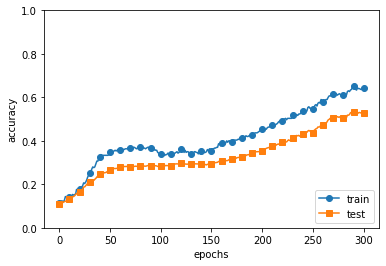

In [29]:
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

그림과 같이 드롭아웃을 적용하니 훈련 데이터와 시험 데이터에 대한 정확도 차이가 줄었다. 이처럼 드롭아웃을 이용하면 표현력을 높이면서도 오버피팅을 억제할 수 있다.

# 6.5 적절한 하이퍼파라미터 값 찾기
신경망에는 하이퍼파라미터가 다수 등장한다. 여기서 말하는 하이퍼파라미터는, 예를 들어 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등이다. 이러한 하이퍼파라미터의 값을 적절히 설정하지 않으면 모델의 성능이 크게 떨어지기도 한다. 하이퍼파라미터의 값은 매우 중요하지만 그 값을 결정하기까지는 일반적으로 많은 시행착오를 겪는다.

## 6.5.1 검증 데이터
하이퍼파라미터를 다양한 값으로 설정하고 검증함에 있어서 주의할 점은 하이퍼파라미터의 성능을 평가할 떄는 시험 데이터를 사용해서 안 된다는 점이다. <br><br>
시험 데이터를 사용하여 하이퍼파라미터를 조정하면 하이퍼파라미터 값이 시험 데이터에 오버피팅되기 때문이다. 바꾸어 말하면, 하이퍼파라미터 값의 '좋음'을 시험 데이터로 확인하게 되므로 하이퍼파라미터의 값이 시험 데이터에만 적합하도록 조정되어 버린다. <br><br>
그래서 하이퍼파라미터를 조정할 때는 하이퍼파라미터 전용 확인 데이터가 필요하다. 하이퍼파라미터 조정용 데이터를 일반적으로 **검증 데이터**라고 부른다.

> 훈련 데이터는 매개변수(가중치와 편향)의 학습에 이용하고, 검증 데이터는 하이퍼파라미터의 성능을 평가하는 데 이용한다. 시험 데이터는 범용 성능을 확인하기 위해서 마지막에 이용한다.
- 훈련 데이터 : 매개변수 학습
- 검증 데이터 : 하이퍼파라미터 성능 평가
- 시험 데이터 : 신경망의 범용 성능 평가

이 코드는 훈련 데이터를 분리하기 전에 입력 데이터와 정답 데이터를 뒤섞는다. 데이터셋 안의 데이터가 치우쳐 있을지도 모르기 때문이다. 그리고 훈련 데이터 중 20% 정도를 검증 데이터로 분리한다.

In [32]:
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

## 6.5.2 하이퍼파라미터 최적화
하이퍼파라미터를 최적화할 때의 핵심은 하이퍼파라미터의 '최적 값'이 존재하는 범위를 조금씩 줄여간다는 것이다. 범위를 조금씩 줄이려면 우선 대략적인 범위를 설정하고 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸(샘플링) 후, 그 값으로 정확도를 평가한다. 정확도를 잘 살피면서 이 작업을 여러 번 반복하며 하이퍼파라미터의 '최적 값'의 범위를 좁혀가는 것이다.

> 신경망의 하이퍼파라미터 최적화에서는 그리드 서치같은 규칙적인 탐색보다는 무작위로 샘플링해 탐색하는 편이 좋은 결과를 낸다고 알려져 있다. 이는 최종 정확도에 미치는 영향력이 하이퍼파라미터마다 다르기 때문이다.

하이퍼파라미터의 범위는 '대략적으로' 지정하는 것이 효과적이다. 실제로도 0.001에서 1,000 사이와 같이 '10의 거듭제곱 '단위로 범위를 지정한다. 이를 **'로그 스케일로 지정'**한다고 한다.<br><br>
하이퍼파라미터를 최적화할 때는 딥러닝 학습에는 오랜 시간이 걸린다는 점을 기억해야 한다. 따라서 나쁠 듯한 값은 일찍 포기하는게 좋다. 그래서 학습을 위한 에폭을 작게 하여, 1회 평가에 걸리는 시간을 단축하는 것이 효과적이다.

- 0단계  
하이퍼파라미터의 값의 범위를 설정한다.
- 1단계  
설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출한다.
- 2단계  
1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가한다. (단, 에폭은 작게 설정한다.)
- 3단계  
1단계와 2단계를 특정 횟수 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

> 위에서 설명한 하이퍼파라미터 최적화 방법은 실용적인 방법이다. 더 세련된 기법을 원한다면 **베이즈 최적화**를 소개할 수 있다. 베이즈 최적화는 베이즈 정리를 중심으로 한 수학 이론을 구사하여 더 엄밀하고 효율적으로 최적화를 수행한다.

## 6.5.3 하이퍼파라미터 최적화 구현하기

val acc:0.8843333333333333 | lr:0.0009420012003572509, weight decay:2.5203551248885168e-05
val acc:0.1035 | lr:4.9003668081306595e-06, weight decay:8.434069136812608e-07
val acc:0.1095 | lr:1.3308668260588149e-05, weight decay:5.8667250864281984e-05
val acc:0.09125 | lr:2.641958890410815e-06, weight decay:2.2437867105816498e-06
val acc:0.806 | lr:0.000438232244620211, weight decay:1.3091969594126784e-08
val acc:0.8625833333333334 | lr:0.000794236361714687, weight decay:3.477916212774688e-05
val acc:0.093 | lr:2.744396305012964e-06, weight decay:2.774741667072633e-08
val acc:0.114 | lr:9.634395637788288e-06, weight decay:5.2940031690467075e-06
val acc:0.9270833333333334 | lr:0.0026102773534745737, weight decay:1.2690350576938182e-07
val acc:0.0895 | lr:1.581071278711296e-05, weight decay:3.4826405846721324e-07
val acc:0.9345 | lr:0.0034015467481139762, weight decay:1.7652010925470854e-07
val acc:0.954 | lr:0.008152355699251391, weight decay:7.261002414645455e-06
val acc:0.33333333333333

val acc:0.92575 | lr:0.0028228418396702005, weight decay:4.644427047780259e-06
val acc:0.11558333333333333 | lr:1.1734494265583923e-06, weight decay:4.4346329491055995e-07
val acc:0.076 | lr:6.657356467642143e-06, weight decay:2.043040895909836e-05
val acc:0.9475833333333333 | lr:0.006102447619820616, weight decay:1.246367860849461e-06
val acc:0.13116666666666665 | lr:2.855407019447709e-05, weight decay:6.444602135511301e-08
=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.954) | lr:0.008152355699251391, weight decay:7.261002414645455e-06
Best-2(val acc:0.9506666666666667) | lr:0.008215292901708098, weight decay:1.5855639666821412e-07
Best-3(val acc:0.9495833333333333) | lr:0.007534087160349785, weight decay:4.01252108765196e-05
Best-4(val acc:0.9475833333333333) | lr:0.006102447619820616, weight decay:1.246367860849461e-06
Best-5(val acc:0.9470833333333334) | lr:0.0053467172621287804, weight decay:1.6391798873516775e-07
Best-6(val acc:0.9398333333333333) | 

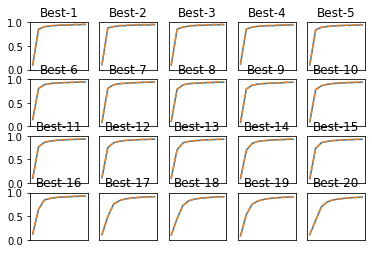

In [35]:
import sys, os
sys.path.append(os.pardir)  
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.trainer import Trainer

def __train(lr, weight_decay, epocs=10):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}

for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

결과를 보면 학습이 잘 진행될 떄의 학습률은 0.001 0.01, 가중치 감소 계소는 $10^{-2}$ ~ $10^{-6}$정도라는 것을 알 수 있다. 이처럼 잘될 것 같은 값의 범위를 관찰하고 범위를 좁혀간다. 그런 다음 그 축소된 범위로 똑같은 작업을 반복한다. 이렇게 적절한 값이 위치한 범위를 좁혀가다가 특정 단계에서 최종 하이퍼파라미터 값을 하나 선택한다.

# 6.6 정리
- 매개변수 갱신 방법에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있다.
- 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.
- 가중치의 초깃값으로는 'Xavier 초깃값과 'He 초깃값'이 효과적이다.
- 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다.
- 오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.
- 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다.